# Initialization

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from pandas import DataFrame
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import load_model

# import IPython
# !pip install -q -U keras-tuner==1.0.1
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

SMALL_SIZE = 20//1.4
MEDIUM_SIZE = 24//1.4
BIGGER_SIZE = 28//1.4

plt.rc('font', size=SMALL_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)   
plt.rc('xtick', labelsize=SMALL_SIZE)   
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)   
plt.rc('figure', titlesize=BIGGER_SIZE) 

def set_seed(seedNum = 42):
    np.random.seed(seedNum)
    tf.random.set_seed(seedNum)

In [2]:
seedNum = 43
set_seed(seedNum)

def scaler(X_train, X_valid, X_test, scalerObj = False):
    '''standard scaling'''
    if scalerObj:
        X_train = scalerObj.transform(X_train)
    else:
        scalerObj = StandardScaler()
        X_train = scalerObj.fit_transform(X_train)
    X_valid = scalerObj.transform(X_valid)
    X_test = scalerObj.transform(X_test)
    return X_train, X_valid, X_test, scalerObj

def preprocessing(X,
                  Y,
                  NumInputs,
                  NumOutputs,
                  scalerList=False,
                  test_size=0.25,
                  random_state=seedNum,
                  NumberOfSamples=300,
                  modelType='RNN'):
    
    '''preprocessing the datasets'''
    
    if not scalerList: scalerList = [False] * (NumOutputs + 1)
    #import pdb; pdb.set_trace()
    X_train_full, X_test, y_train_full, y_test = train_test_split(X,
                                                                  Y,
                                                                  test_size=test_size,
                                                                  random_state=random_state)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                          y_train_full,
                                                          test_size=0.25,
                                                          random_state=random_state)
    
    X_train, X_valid, X_test, scalerList[0] = scaler(X_train,
                                                     X_valid,
                                                     X_test,
                                                     scalerList[0])
    
    for i in range(NumOutputs):
        y_train[:,:,i], y_valid[:,:,i], y_test[:,:,i], scalerList[i+1] = scaler(y_train[:,:,i],
                                                                                y_valid[:,:,i],
                                                                                y_test[:,:,i],
                                                                                scalerList[i+1])
    
    y_train = y_train.reshape(y_train.shape[0], -1)
    y_valid = y_valid.reshape(y_valid.shape[0], -1)
    y_test = y_test.reshape(y_test.shape[0], -1)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, scalerList[:]

# Data generation runtime

In [3]:
time_hf = np.loadtxt('time_input_2d.csv', delimiter=",", dtype='float32')
time_lf = np.loadtxt('time_output_2d_lowfidelity.csv', delimiter=",", dtype='float32')
time_2d = (time_hf - time_lf) / time_lf

time_hf = np.loadtxt('time_input_3d.csv', delimiter=",", dtype='float32')
time_lf = np.loadtxt('time_output_3d_lowfidelity.csv', delimiter=",", dtype='float32')
time_3d = (time_hf - time_lf) / time_lf

<ipython-input-4-dea126c94666>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


<Figure size 432x288 with 0 Axes>

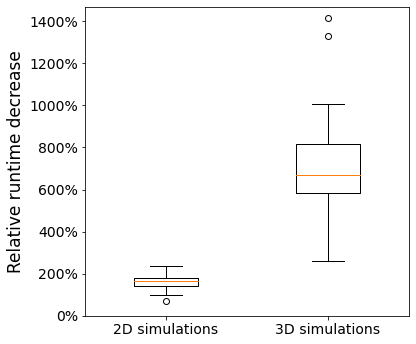

In [4]:
plt.clf()

data = [time_2d, time_3d]

ticks = ['2D simulations', '3D simulations']

plt.figure(figsize=(6, 5))

plt.boxplot(data, labels=ticks,widths=0.4)


plt.ylim(0, np.max(data)+0.5)
plt.ylabel('Relative runtime decrease')

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.tight_layout()
plt.savefig('compare.pdf', format='pdf', dpi=500)

# 2D models

In [5]:
class newHyperModel(HyperModel):
    
    '''tuner for keras models'''
    
    def __init__(self, first_units, last_units, X_train, num_layers = 4):
        self.last_units = last_units
        self.first_units = first_units
        self.num_layers = num_layers
        self.X_train = X_train
    
    def build(self, hp):
        
        '''model architectures'''
        
        activationList = ['relu', 'elu']
        activation=hp.Choice('activation_function', values=activationList)
        units=hp.Int('units', min_value=self.first_units*10, max_value=self.last_units//10, step=30)
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]))
        model = keras.models.Sequential()
        
        for i in range(hp.Int('num_layers',1,self.num_layers)):
            model.add(BatchNormalization())
            model.add(Dense(units=units, activation=activation))
        
        model.add(Dense(self.last_units))
        
        model.compile(loss="mean_squared_error",optimizer=optimizer)
        
        return model

In [6]:
class ml_tools():
    
    def __init__(self, inputPath='input.csv', outputPath='output.csv', patience=20,
                 epochs=200, modelType='DL', analysis='3D'):
        
        X = np.loadtxt(inputPath, delimiter=",", dtype='float32')
        Y = np.loadtxt(outputPath, delimiter=",", dtype='float32')
        
        
        NumberOfSamples = int(X[-1][-1])
        
        # removing identifier of samples in each dataset:
        Y = Y[:,:-1]
        X = X[:,:-1]
        
        NumInputs = X.shape[-1]
        NumOutputs = Y.shape[-1]
        
        # fixing the dimentions:
        X = X.reshape(NumberOfSamples, -1, NumInputs)
        # import pdb; pdb.set_trace()
        Y = Y.reshape(NumberOfSamples, -1, NumOutputs)
        
        NumberOfSamples = NumberOfSamples//2
        
        if analysis == '2D_Axial':
            X, Y = X[::2,:,:], Y[::2,:,:]
        
        elif analysis == '2D_Shear':
            X, Y = X[1::2,:,:], Y[1::2,:,:]
        
        
        X = X.reshape(NumberOfSamples, -1)
        self.NumInputs = NumInputs
        self.NumOutputs = NumOutputs
        self.X = X
        self.Y = Y
        self.NumberOfSamples = NumberOfSamples
        self.epochs = epochs
        self.patience = patience
        self.inputPath = inputPath
        self.modelType = modelType
    
    def tuner(self):
        
        result = [self.modelType]
        
        if self.modelType[-2:] == 'DL':
            
            hpModel = newHyperModel(X_train=self.X_train,
                                    first_units=self.NumInputs,
                                    last_units=self.y_train.shape[-1])
            
            tuner = RandomSearch(hpModel,
                                 objective='val_loss',
                                 seed=self.seedNum,
                                 max_trials=self.max_trials,
                                 executions_per_trial=3,
                                 directory='dir',
                                 overwrite = True,
                                 project_name='project')
            
            early_stopping_cb = keras.callbacks.EarlyStopping(patience=self.patience,
                                                              restore_best_weights=True)
            set_seed(self.seedNum)
            tuner.search(self.X_train, self.y_train,
                         epochs=self.epochs,
                         # batch_size = 3,
                         validation_data=(self.X_valid, self.y_valid),
                         callbacks=[early_stopping_cb],
                         verbose=0)
            
            models = tuner.get_best_models(num_models=1)
            # set_seed(self.seedNum)
            # early_stopping_cb = keras.callbacks.EarlyStopping(patience=self.patience,
            #                                                   restore_best_weights=True)
            # models[0].fit(self.X_train,
            #               self.y_train,
            #               # batch_size = 3,
            #               epochs=self.epochs*10,
            #               validation_data=(self.X_valid, self.y_valid),
            #               callbacks=[early_stopping_cb],
            #               verbose=0)
            
            result.append(models[0].evaluate(self.X_valid, self.y_valid))
            result.append(models[0].evaluate(self.X_test, self.y_test))
            result.append(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)
            
        else:
            param = {'estimator__learning_rate':     [0.05,0.1,0.15,0.2],
                     'estimator__n_estimators':      range(10,50,10),
                     'estimator__max_depth':         range(1,5,1),
                     'estimator__min_samples_split': range(2,6,1),
                     'estimator__min_samples_leaf':  range(2,18,3)}
            
            estimator = MultiOutputRegressor(GradientBoostingRegressor(max_features='sqrt',
                                                                       subsample=0.8,
                                                                       random_state=10))
            search = RandomizedSearchCV(estimator = estimator, 
                                        param_distributions = param,
                                        scoring='neg_mean_squared_error',
                                        n_iter = self.max_trials,
                                        n_jobs=-1,
                                        cv=3)
            search.fit(self.X_train, self.y_train)
            result.append(mean_squared_error(search.best_estimator_.predict(self.X_valid[:])[:], self.y_valid[:]))
            result.append(mean_squared_error(search.best_estimator_.predict(self.X_test[:])[:], self.y_test[:]))
            result.append(search.best_params_)
        
        return result
    
    def run(self, rangeList=[0.98,0.95], numOutputResults=1, runModel=True, max_trials=30, modelList=['DL'], seedNum=43):
        
        self.max_trials = max_trials
        self.seedNum = seedNum
        NumOutputs = self.NumOutputs = numOutputResults
        NumInputs = self.NumInputs
        
        result = []
        for r in rangeList:
            
            temp = preprocessing(self.X,
                                 self.Y[:,:,:numOutputResults],
                                 NumInputs,
                                 NumOutputs,
                                 random_state=seedNum,
                                 test_size=r,
                                 NumberOfSamples=self.NumberOfSamples,
                                 modelType=self.modelType)
            
            self.X_train, self.X_valid, self.X_test, self.y_train, self.y_valid, self.y_test, _ = temp
            
            for self.modelType in modelList:
                print('#_X_train = {}, #_X_valid = {}, modelType = {}, range = {}'.format(self.X_train.shape[0],
                                                                                          self.X_valid.shape[0],
                                                                                          self.modelType,
                                                                                          r))
                result.append(self.tuner())
                result[-1].append(self.X_train.shape[0])
        
        return result

In [7]:
class ml_tools():
    
    def __init__(self, inputPath='input.csv', outputPath='output.csv', patience=20,
                 epochs=200, modelType='DL', analysis='3D'):
        
        X = np.loadtxt(inputPath, delimiter=",", dtype='float32')
        Y = np.loadtxt(outputPath, delimiter=",", dtype='float32')
        
        
        NumberOfSamples = int(X[-1][-1])
        
        # removing identifier of samples in each dataset:
        Y = Y[:,:-1]
        X = X[:,:-1]
        
        NumInputs = X.shape[-1]
        NumOutputs = Y.shape[-1]
        
        # fixing the dimentions:
        X = X.reshape(NumberOfSamples, -1, NumInputs)
        # import pdb; pdb.set_trace()
        Y = Y.reshape(NumberOfSamples, -1, NumOutputs)
        
        NumberOfSamples = NumberOfSamples//2
        
        if analysis == '2D_Axial':
            X, Y = X[::2,:,:], Y[::2,:,:]
        
        elif analysis == '2D_Shear':
            X, Y = X[1::2,:,:], Y[1::2,:,:]
        
        
        X = X.reshape(NumberOfSamples, -1)
        self.NumInputs = NumInputs
        self.NumOutputs = NumOutputs
        self.X = X
        self.Y = Y
        self.NumberOfSamples = NumberOfSamples
        self.epochs = epochs
        self.patience = patience
        self.inputPath = inputPath
        self.modelType = modelType
    
    def tuner(self):
        
        result = [self.modelType]
            
        hpModel = newHyperModel(X_train=self.X_train,
                                first_units=self.NumInputs,
                                last_units=self.y_train.shape[-1])
        
        tuner = RandomSearch(hpModel,
                             objective='val_loss',
                             seed=self.seedNum,
                             max_trials=self.max_trials,
                             executions_per_trial=3,
                             directory='dir',
                             overwrite = True,
                             project_name='project')
        
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=self.patience,
                                                          restore_best_weights=True)
        set_seed(self.seedNum)
        tuner.search(self.X_train, self.y_train,
                     epochs=self.epochs,
                     # batch_size = 3,
                     validation_data=(self.X_valid, self.y_valid),
                     callbacks=[early_stopping_cb],
                     verbose=0)
        
        models = tuner.get_best_models(num_models=1)
        # set_seed(self.seedNum)
        # early_stopping_cb = keras.callbacks.EarlyStopping(patience=self.patience,
        #                                                   restore_best_weights=True)
        # models[0].fit(self.X_train,
        #               self.y_train,
        #               # batch_size = 3,
        #               epochs=self.epochs,
        #               validation_data=(self.X_valid, self.y_valid),
        #               callbacks=[early_stopping_cb],
        #               verbose=0)
        # 
        result.append(models[0].evaluate(self.X_valid, self.y_valid))
        result.append(models[0].evaluate(self.X_test, self.y_test))
        result.append(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)
            
        return result
    
    def run(self, rangeList=[0.98,0.95], numOutputResults=1, runModel=True, max_trials=30, modelList=['DL'], seedNum=43):
        
        self.max_trials = max_trials
        self.seedNum = seedNum
        NumOutputs = self.NumOutputs = numOutputResults
        NumInputs = self.NumInputs
        
        result = []
        for r in rangeList:
            
            temp = preprocessing(self.X,
                                 self.Y[:,:,:numOutputResults],
                                 NumInputs,
                                 NumOutputs,
                                 random_state=seedNum,
                                 test_size=r,
                                 NumberOfSamples=self.NumberOfSamples,
                                 modelType=self.modelType)
            
            self.X_train, self.X_valid, self.X_test, self.y_train, self.y_valid, self.y_test, _ = temp
            
            for self.modelType in modelList:
                print('#_X_train = {}, #_X_valid = {}, modelType = {}, range = {}'.format(self.X_train.shape[0],
                                                                                          self.X_valid.shape[0],
                                                                                          self.modelType,
                                                                                          r))
                result.append(self.tuner())
                result[-1].append(self.X_train.shape[0])
                #result.append({'tuned': self.tuner(), 'modelType': self.modelType})
        
        return result

In [8]:
def run_tuner(rangeList, patience=30, epochs=100, max_trials=120, numOutputResults=2, analysis='3D', seedNum=42):
    
    rangeList = rangeList.tolist()
    result = []
    tuner = ml_tools(inputPath='input_2d.csv',
                         outputPath='output_2d_highfidelity.csv',
                         patience=patience,
                         epochs=epochs,
                         analysis=analysis)
    
    result.extend(tuner.run(rangeList=rangeList,
                            numOutputResults=numOutputResults,
                            max_trials=max_trials,
                            modelList=['DL'],
                            seedNum=seedNum))
    
    tuner = ml_tools(inputPath='output_2d_lowfidelity.csv',
                         outputPath='output_2d_highfidelity.csv',
                         patience=patience,
                         epochs=epochs,
                         analysis=analysis)
    
    result.extend(tuner.run(rangeList=rangeList,
                            numOutputResults=numOutputResults,
                            max_trials=max_trials,
                            modelList=['HML-DL'],
                            seedNum=seedNum))
    return result

In [9]:
# Hyperparameters of hyperparameter tuner:

rangeList = np.arange(0.90,0.49,-0.1)
epochsList=[1000, 500]

patienceList=[300, 200]
max_trialsList=[20, 20]

numOutputResultsList=[3, 5]
analysisList=['2D_Axial', '2D_Shear']

In [10]:
results = []
for patience, epochs, max_trials, numOutputResults, analysis in zip(patienceList,
                                                                    epochsList,
                                                                    max_trialsList,
                                                                    numOutputResultsList,
                                                                    analysisList):
    results.append(run_tuner(rangeList,
                             patience=patience,
                             epochs=epochs,
                             max_trials=max_trials,
                             numOutputResults=numOutputResults,
                             analysis=analysis,
                             seedNum = seedNum))

#_X_train = 3, #_X_valid = 2, modelType = DL, range = 0.9


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 0.096 - 0s 2ms/step - loss: 0.0993
#_X_train = 7, #_X_valid = 3, modelType = DL, range = 0.8


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 0.041 - 0s 2ms/step - loss: 0.0439
#_X_train = 11, #_X_valid = 4, modelType = DL, range = 0.7000000000000001


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 0.008 - 0s 1ms/step - loss: 0.0083
#_X_train = 14, #_X_valid = 5, modelType = DL, range = 0.6000000000000001


INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - ETA: 0s - loss: 0.030 - 0s 3ms/step - loss: 0.0305
#_X_train = 18, #_X_valid = 6, modelType = DL, range = 0.5000000000000001


INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - ETA: 0s - loss: 0.007 - 0s 0s/step - loss: 0.0077
#_X_train = 3, #_X_valid = 2, modelType = HML-DL, range = 0.9


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 0.008 - 0s 1ms/step - loss: 0.0081
#_X_train = 7, #_X_valid = 3, modelType = HML-DL, range = 0.8


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 0.004 - 0s 8ms/step - loss: 0.0046
#_X_train = 11, #_X_valid = 4, modelType = HML-DL, range = 0.7000000000000001


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 0.002 - 0s 8ms/step - loss: 0.0022
#_X_train = 14, #_X_valid = 5, modelType = HML-DL, range = 0.6000000000000001


INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - ETA: 0s - loss: 0.013 - 0s 0s/step - loss: 0.0131
#_X_train = 18, #_X_valid = 6, modelType = HML-DL, range = 0.5000000000000001


INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - ETA: 0s - loss: 0.004 - 0s 16ms/step - loss: 0.0042
#_X_train = 3, #_X_valid = 2, modelType = DL, range = 0.9


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 4.393 - 0s 8ms/step - loss: 5.4857
#_X_train = 7, #_X_valid = 3, modelType = DL, range = 0.8


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 0.109 - 0s 0s/step - loss: 0.1128
#_X_train = 11, #_X_valid = 4, modelType = DL, range = 0.7000000000000001


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 0.045 - 0s 8ms/step - loss: 0.0420
#_X_train = 14, #_X_valid = 5, modelType = DL, range = 0.6000000000000001


INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - ETA: 0s - loss: 0.092 - 0s 0s/step - loss: 0.0924
#_X_train = 18, #_X_valid = 6, modelType = DL, range = 0.5000000000000001


INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - ETA: 0s - loss: 0.061 - 0s 2ms/step - loss: 0.0613
#_X_train = 3, #_X_valid = 2, modelType = HML-DL, range = 0.9


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 0.849 - 0s 8ms/step - loss: 1.2323
#_X_train = 7, #_X_valid = 3, modelType = HML-DL, range = 0.8


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - 0s 8ms/step - loss: 0.0012
#_X_train = 11, #_X_valid = 4, modelType = HML-DL, range = 0.7000000000000001


INFO:tensorflow:Oracle triggered exit
2/2 [==============================] - ETA: 0s - loss: 6.6307e-0 - 0s 8ms/step - loss: 6.6433e-04
#_X_train = 14, #_X_valid = 5, modelType = HML-DL, range = 0.6000000000000001


INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - ETA: 0s - loss: 3.7575e-0 - 0s 0s/step - loss: 3.7575e-04
#_X_train = 18, #_X_valid = 6, modelType = HML-DL, range = 0.5000000000000001


INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - ETA: 0s - loss: 3.4042e-0 - 0s 0s/step - loss: 3.4042e-04


In [11]:
with open("results_2D.p", "wb") as f: pickle.dump(results, f)

In [12]:
with open("results_2D.p","rb") as f: results = pickle.load(f)

In [21]:
# to extract the table in the Supplementary Materials of the paper.

table = dict()
items = results[0] + results[1]

v = 0

for testType in ['Axial test','Shear test']:
    
    for p in range(5):
        i = p + v
        j = items[i]
        k = items[i+5]
        
        if j[3]['activation_function'] == 'relu':
            j[3]['activation_function'] = 'ReLU'
        else:
            j[3]['activation_function'] = 'ELU'
        
        
        if k[3]['activation_function'] == 'relu':
            k[3]['activation_function'] = 'ReLU'
        else:
            k[3]['activation_function'] = 'ELU'
        
        numSampels = j[-1]
        
        table['%s (%s)'%(testType,numSampels)] = {'Activation function':'%s/%s'%(j[3]['activation_function'],k[3]['activation_function']),
                                                  '#Neurons in each hidden layer':'%s/%s'%(j[3]['units'],k[3]['units']),
                                                  'Learning rate':'%s/%s'%(j[3]['learning_rate'],k[3]['learning_rate']),
                                                  '#Hidden layers':'%s/%s'%(j[3]['num_layers'],k[3]['num_layers'])}
    v = 10

df = DataFrame(table)
df = df.T

print(df.to_latex())

\begin{tabular}{lllll}
\toprule
{} & Activation function & \#Neurons in each hidden layer &  Learning rate & \#Hidden layers \\
\midrule
Axial test (3)  &             ELU/ELU &                       120/110 &  0.0001/0.0001 &            1/1 \\
Axial test (7)  &             ELU/ELU &                       180/140 &    0.001/0.001 &            3/2 \\
Axial test (11) &             ELU/ELU &                       210/200 &    0.001/0.001 &            3/3 \\
Axial test (14) &             ELU/ELU &                       150/140 &    0.001/0.001 &            2/3 \\
Axial test (18) &             ELU/ELU &                       150/230 &    0.001/0.001 &            3/3 \\
Shear test (3)  &             ELU/ELU &                        90/200 &  0.0001/0.0001 &            4/1 \\
Shear test (7)  &             ELU/ELU &                       330/230 &    0.001/0.001 &            3/2 \\
Shear test (11) &             ELU/ELU &                       210/230 &    0.001/0.001 &            3/3 \\
Shear t

In [14]:
def report_tuner(result, ax):
    
    resultDict = {key: [[],[],[]] for key in ['DL', 'HML-DL']}
    num = 0
    txt = ''
    for i in result:
        num += 1
        modelType, mseValid, mseTest, numSamples = i[0], i[1], i[2], i[4]
    #    if numSamples == 7 or numSamples == 15: continue
        tunedParameters = ''
        for key, value in i[3].items():
            tunedParameters = tunedParameters + '\t{}: {}\n'.format(key, value)
        
        temp = '{}) Model type: {}\nMSE on valid set: {}\nMSE on test set: {}\n'\
                'Tuned hyperparameters: \n{}Number of training samples: {}\n\n'
        txt += temp.format(num,modelType,mseValid,mseTest,tunedParameters,numSamples)
        
        resultDict[modelType][0].append(numSamples)
        resultDict[modelType][1].append(mseValid)
        resultDict[modelType][2].append(mseTest)
    
    for key in resultDict:
        x, y = zip(*sorted(zip(resultDict[key][0], resultDict[key][1])))
        linewidth = 2
        if key[-2:] == 'DL':
            style = 'bo'
        else:
            style = 'rs'
        
        if key[:3] != 'HML':
            style = '--' + style
        else:
            style = '-' + style
        
        # ax.plot(x, y, style, label=key, linewidth=linewidth)
        ax.plot(x, y, style, linewidth=linewidth)
        
        ax.set_xticks(range(min(x), max(x), 4))
    
    # plt.show
    return ax, txt

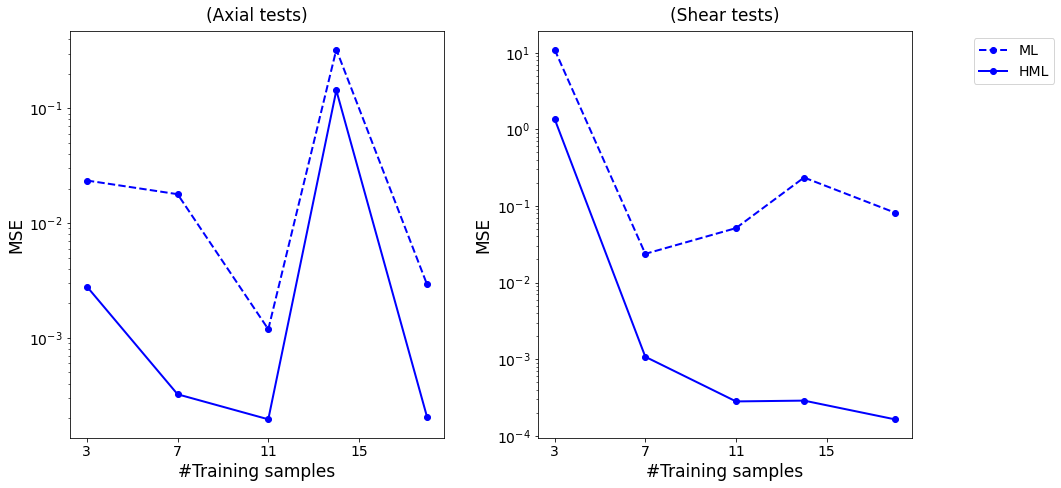

In [16]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

p = 0
with open('tuned_parameters.txt', 'w') as file:
    for res,analysis in zip(results,['Axial','Shear']):
        
        title = '\nTunned hyperparameters for the models in {} tests:\n\n'.format(analysis)
        ax[p], txt = report_tuner(res, ax[p])
        ax[p].set_yscale('log')
        # ax[m,n].set_yscale('linear')
        # ax[m,n].set_ylim([-0.01,0.01])
        if p == 1:
            ax[p].legend(['ML','HML'],bbox_to_anchor= (1.4,1))
        
        # if m == 0 and n == 0: ax[m,n].legend()
        file.write(title + txt)
        ax[p].set(xlabel='#Training samples', ylabel='MSE')
        ax[p].set_title('({} tests)'.format(analysis), pad=10)
        p += 1


fig.tight_layout()
fig.subplots_adjust(wspace=0.25 , hspace=0.25)
fig.savefig('2D_tuner.pdf', format='pdf', dpi=500);

# 3D simulation

In [93]:
# high-fidelity data

inputPath = 'input_3d.csv'
outputPath = 'output_3d_highfidelity.csv'
X = np.loadtxt(inputPath, delimiter=",", dtype='float32')
Y = np.loadtxt(outputPath, delimiter=",", dtype='float32')
NumberOfSamples = 100
NumInputs = dict()
NumInputs['ML'] = X.shape[-1]
NumOutputs = Y.shape[-1]
Y = Y.reshape(NumberOfSamples, -1, NumOutputs)
X = X.reshape(NumberOfSamples, -1)

# low-fidelity data
lfPath='output_3d_lowfidelity.csv'
X_lf = np.loadtxt(lfPath, delimiter=",", dtype='float32')
X_lf = X_lf.reshape(NumberOfSamples,-1,3).reshape(NumberOfSamples,-1)
NumInputs['HML'] = X_lf.shape[-1]

In [94]:
def train_model(X, Y, epochs, modelType, test_size, patience, NumInputs, NumOutputs, num_layers, denominator, lr = 1e-5, activation= 'relu'):
    
    X_train, X_valid, X_test, y_train, y_valid, y_test, scaler = preprocessing(X = X,
                                                                               Y = Y,
                                                                               NumInputs = NumInputs,
                                                                               NumOutputs = NumOutputs,
                                                                               test_size = test_size,
                                                                               modelType = modelType)
    last_units=y_train.shape[-1]
    units = last_units//denominator
    
    set_seed()
    model = keras.models.Sequential()
    
    for i in range(num_layers):
        model.add(BatchNormalization())
        model.add(Dense(units=units, activation=activation))
    
    model.add(Dense(last_units))
    model.compile(loss="mean_squared_error",
                  optimizer=keras.optimizers.Adam(lr))
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience,
                                                      restore_best_weights=True)
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping_cb],
                        verbose=0)
    
    pmse = np.mean(np.square(y_test - model.predict(X_test)), axis=0).reshape(1,-1).reshape(1,-1,NumOutputs)
    pmse = np.average(pmse, axis=2)
    
    return {'history':history, 'pmse':pmse}

In [95]:
epochsList = [100, 100, 1000, 1000]
test_sizeList=[0.96, 0.96, 0.96, 0.80]
patienceList = [100, 100, 100, 100]
num_layersList = [4, 4, 4, 4]
denominatorList = [100, 100, 1000, 100]
lrList=[1e-4, 1e-4, 1e-3, 1e-4]
activationList=['relu', 'elu', 'relu', 'relu']

In [97]:
result3d = []
for epochs,test_size,patience,num_layers,denominator,lr,activation in zip(epochsList,
                                                                          test_sizeList,
                                                                          patienceList,
                                                                          num_layersList,
                                                                          denominatorList,
                                                                          lrList,
                                                                          activationList):
    result=dict()
    for x, modelType in zip([X, X_lf], ['ML','HML']):
        
        start = time.time()
        result[modelType] = train_model(X = x,
                                        Y = Y,
                                        modelType = modelType,
                                        epochs = epochs,
                                        test_size=test_size,
                                        patience = patience,
                                        NumInputs = NumInputs[modelType],
                                        NumOutputs = NumOutputs,
                                        num_layers = num_layers,
                                        denominator = denominator,
                                        lr=lr,
                                        activation=activation)
        end = time.time()
        print("Elapsed Time: %s"%((end - start)/60))
    result3d.append(result)

Elapsed Time: 0.6869594772656759
Elapsed Time: 0.7509115894635519
Elapsed Time: 0.8407311717669169
Elapsed Time: 0.8133500218391418
Elapsed Time: 0.10909902254740397
Elapsed Time: 0.36937708854675294
Elapsed Time: 8.280859740575155
Elapsed Time: 4.929101463158926


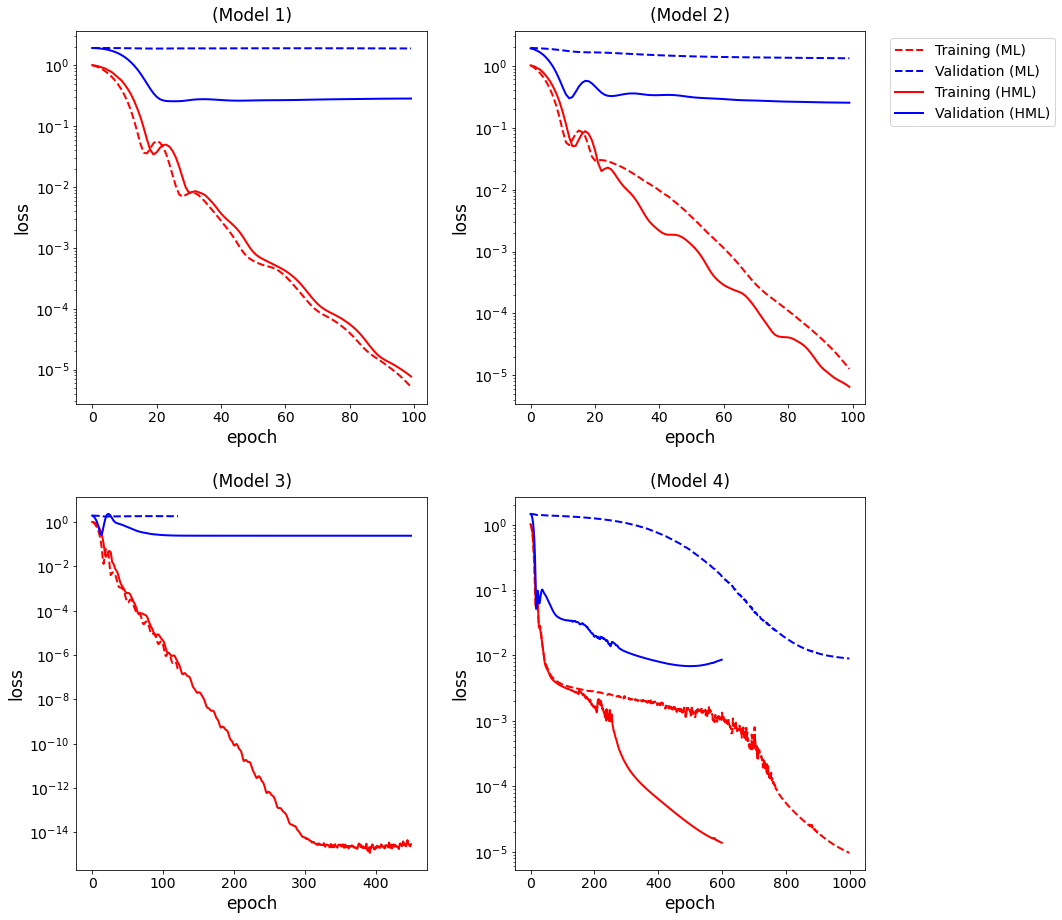

In [115]:
fig, ax = plt.subplots(2,2,figsize=(15,13))
lst = []
k = 0
m = 0
n = 0
p = 0
for result in result3d:
    p += 1
    for modelType in list(result.keys()):
        k += 1
        if p == 1:
            m, n = 0, 0
        elif p == 2:
            m, n = 0, 1
        elif p == 3:
            m, n = 1, 0
        elif p == 4:
            m, n = 1, 1
        
        temp = []
        if modelType == 'ML':
            style = '--'
        else:
            style = '-'
        history = result[modelType]['history']
        ax[m,n].plot(history.history['loss'], 'r' + style, linewidth=2)
        ax[m,n].plot(history.history['val_loss'], 'b' + style, linewidth=2)
    
    #ax[m,n].legend(loc='upper right')
    ax[m,n].set_ylabel('loss')
    ax[m,n].set_xlabel('epoch')
    ax[m,n].set_yscale('log')
    
    if m == 0 and n == 1:
        ax[m,n].legend(['Training (ML)','Validation (ML)','Training (HML)','Validation (HML)'], bbox_to_anchor= (1.05,1))
    #else:
    #    ax[m,n].legend()
    
    # if not p==2: ax[m,n].legend()
    ax[m,n].set_title('(Model %s)'%(p), pad=10)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.25 , hspace=0.25)
fig.savefig('3D.pdf', format='pdf', dpi=500)

### Visualization

In [20]:
def abaqus(data, num_outputs = 1, header = ['S11', 'S22', 'S33'], title = 'First testing sample', script = 'Visualization.py'):
    
    path = 'temp_' + title.replace(' ', '_')
    data = data.reshape(-1,num_outputs)
    data = data[:,:len(header)]
    np.savetxt(path, X = data, delimiter=",")
    
    # adding the path variable in Visualization.py:
    txt = []
    with open(script, 'r') as f:
        txt = f.readlines()
        idx = txt.index('# START OF AUTOMATICALLY GENERATED PYTHON CODE\n')
        txt[idx + 1] = 'path = "%s"\n'%(path)
    
    with open(script, 'w') as f: f.writelines(txt)
    
    # run abaqus
    parentFolder = 'C:\\temp\\HybridMl\\'
    os.system('abaqus cae noGUI=' + parentFolder + 'Visualization.py');
    
    lst = [i for i in os.listdir() if path == i[:len(path)] and 'png'== i[-3:]]
    img = [mpimg.imread(i)[150:-150, 200:-200, :] for i in lst]
    
    return img

In [21]:
data = [result3d[0]['ML']['pmse'],
        result3d[0]['HML']['pmse'],
        result3d[1]['ML']['pmse'],
        result3d[1]['HML']['pmse'],
        result3d[2]['ML']['pmse'],
        result3d[2]['HML']['pmse'],
        result3d[3]['ML']['pmse'],
        result3d[3]['HML']['pmse']]

In [22]:
col = header = ['ML', 'HML']
row = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

In [23]:
img = []
for d in data:
    img.append(abaqus(d, header = header, title = 'temp'))

<Figure size 432x288 with 0 Axes>

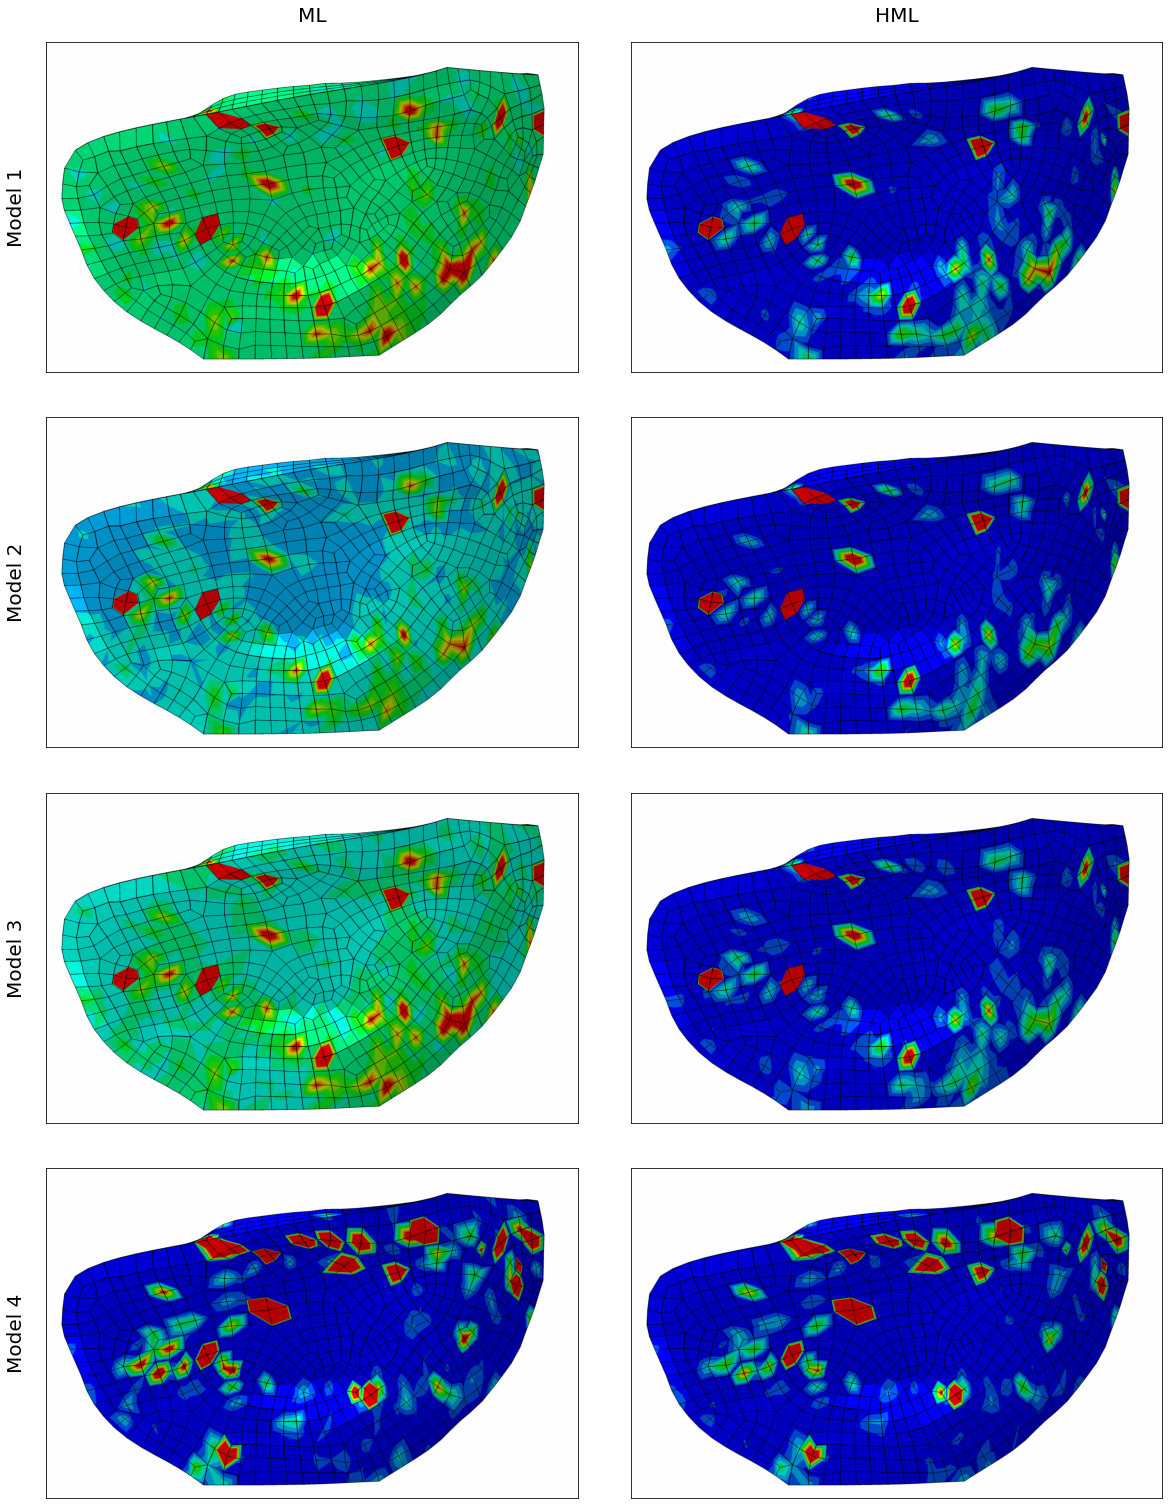

In [24]:
plt.clf();

fig = plt.figure(figsize=(20, 27))

columns = len(col)
rows = len(row)

ax = []
for i , image in zip(range(columns*rows), img):
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    
    if i < columns:
        ax[-1].set_title(col[i], size=20, pad=20)
        ax[-1].title.set_position([.5, 1.1])
    
    if i % columns == 0:
        ax[-1].set_ylabel(row[i//columns], rotation=90, size=20)
        ax[-1].yaxis.labelpad = 20
    
    # ax[-1].axis('off')
    plt.imshow(image[0])

fig.subplots_adjust(wspace=0.1 , hspace=0.1)
fig.savefig('visualization_3d.pdf', format='pdf', dpi=300)
plt.show()